In [132]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

In [133]:
# DIR = "data/C/training"

# for root, _, files in os.walk(DIR):
#     for file in files:
#         if file.lower().endswith(('.png')):
#             file_path = os.path.join(root, file)
#         try:
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 if (width != 45):
#                     print(f"File: {file_path}, Size: {width}x{height}")
#         except Exception as e:
#             print(f"Could not open or process {file_path}: {e}")


In [134]:
train_transforms  = transforms.Compose([
    transforms.Grayscale(),           # Convert to 1 channel
    # transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally
    # transforms.RandomRotation(10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(size=(30,30), antialias=False),  # Random crop with slight scaling
    transforms.Resize((45, 45)),      # Match training size
    # transforms.CenterCrop((28,28)),

    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Slight color changes
    transforms.ToTensor(),                       # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))         # Normalize (assuming grayscale, update if RGB)
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),           # Convert to 1 channel  
    transforms.Resize((45, 45)),      # Match training size
    # transforms.CenterCrop((28,28)),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomScrabbleDataset(Dataset):
    def __init__(self, root_dir, split='training', transform=None):
        """
        Args:
            root_dir (str): Path to dataset root.
            split (str): 'training' or 'val'.
            transform (callable, optional): Optional transform to apply to images.
        """
        self.samples = []
        self.labels = []
        self.class_to_idx = {}
        self.transform = transform

        # Each class folder (A, B, ...)
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name, split)
            if not os.path.isdir(class_path):
                continue

            self.class_to_idx[class_name] = idx

            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(class_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path = self.samples[idx]
        label = self.labels[idx]

        # Load the image using PIL
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CustomScrabbleDataset('data', split='training', transform=train_transforms )
val_dataset = CustomScrabbleDataset('data', split='val', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z'
]


In [135]:
# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 3)
#         self.conv2 = nn.Conv2d(8, 16, 3)
#         self.fc1 = nn.Linear(16 * 5 * 5, 64)
#         self.fc2 = nn.Linear(64, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 5 * 5)
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)


# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3)
#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.fc1 = nn.Linear(64 * 5 * 5, 128)
#         self.fc2 = nn.Linear(128, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 64 * 5 * 5)
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)


class LetterClassifier(nn.Module):
    def __init__(self):
        super(LetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 9 * 9, 128)  # updated for 45x45 input
        self.fc2 = nn.Linear(128, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 9 * 9)  # updated
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_accuracy(model, set_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in set_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [137]:
model = LetterClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

val_accs = []
training_accs = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    
    val_acc = get_accuracy(model, val_loader)
    train_acc = get_accuracy(model, train_loader)

    val_accs.append(val_acc)
    training_accs.append(train_acc)

    print(f"EPOCH {epoch} COMPLETE! TRAIN: {train_acc}. VAL: {val_acc}")

x = [i for i in range(num_epochs)]
# Plot both sets of data
plt.plot(x, val_accs, label='Validation Accuracy', color='blue', marker='o')
plt.plot(x, training_accs, label='Training Accuracy', color='red', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()  # Show legend

# Show the plot
plt.show()

/home/bunny2/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:475: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


EPOCH 0 COMPLETE! TRAIN: 5.883912006360986. VAL: 3.8424591738712777
EPOCH 1 COMPLETE! TRAIN: 7.580174927113703. VAL: 11.815561959654179
EPOCH 2 COMPLETE! TRAIN: 13.835144447389345. VAL: 46.10951008645533
EPOCH 3 COMPLETE! TRAIN: 16.3265306122449. VAL: 59.84630163304515
EPOCH 4 COMPLETE! TRAIN: 18.923933209647494. VAL: 75.21613832853026
EPOCH 5 COMPLETE! TRAIN: 19.29499072356215. VAL: 76.46493756003842
EPOCH 6 COMPLETE! TRAIN: 22.76702888947787. VAL: 80.59558117195004
EPOCH 7 COMPLETE! TRAIN: 23.323615160349853. VAL: 88.66474543707973
EPOCH 8 COMPLETE! TRAIN: 24.622316459051152. VAL: 87.223823246878
EPOCH 9 COMPLETE! TRAIN: 26.76914921812881. VAL: 87.80019212295869
EPOCH 10 COMPLETE! TRAIN: 27.749801219188974. VAL: 91.35446685878962
EPOCH 11 COMPLETE! TRAIN: 27.855817651736018. VAL: 88.08837656099904
EPOCH 12 COMPLETE! TRAIN: 28.650940895838854. VAL: 91.73871277617675
EPOCH 13 COMPLETE! TRAIN: 29.234031274847602. VAL: 91.73871277617675
EPOCH 14 COMPLETE! TRAIN: 30.850781871190033. VAL: 

KeyboardInterrupt: 

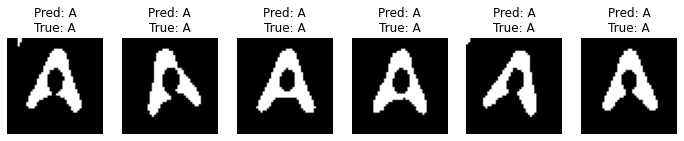

In [ ]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

dataiter = iter(val_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 4))
for idx in range(6):
    plt.subplot(1, 6, idx+1)
    imshow(images[idx])
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")


In [ ]:
torch.save(model.state_dict(), 'letter_classifier.pth')
